# Property Price Register - Machine Learning analysis

## Section 0 - Import required modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import export_graphviz

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score 

import pydot
from IPython.display import Image, display

%matplotlib inline

## Section 1 - Data Understanding and Preparation

### Section 1.x - Introduction

Our objective is to use a sample of the Residential Property Price Register (RPPR) to make inference about the price of houses in the Republic of Ireland. We will explore the dataset, transform the dataset appropriately, train various machine learning models using the dataset, validate these models, and perform tests for generalisability (how well does our final model predict house prices). 

Both the input and target features come from the RPPR, which is a dataset containing details of the sale of all residential properties purchased in Ireland since the 1st January 2010, as declared to the Revenue Commissioners for stamp duty purposes.

### Section 1.x - Read in the cleaned dataset

In [2]:
df = pd.read_csv("cleaned_data.csv")

In [3]:
df.head()

,Date_of_Sale,Postal_Code,County,Price_€_VAT_incl,Description_of_Property,Property_Size_Description,Month_of_Sale,Quarter_of_Sale
0,2020-05-21,unknown,Roscommon,180000.0,Second-Hand Dwelling house /Apartment,unknown,May,2
1,2011-09-08,unknown,Kilkenny,73500.0,Second-Hand Dwelling house /Apartment,unknown,September,3
2,2021-09-24,dublin 15,Dublin,280000.0,Second-Hand Dwelling house /Apartment,unknown,September,3
3,2021-08-18,unknown,Louth,205000.0,Second-Hand Dwelling house /Apartment,unknown,August,3
4,2013-08-02,dublin 9,Dublin,282500.0,Second-Hand Dwelling house /Apartment,unknown,August,3


### Section 1.x: Change the data types

In [4]:
df.dtypes

Date_of_Sale                  object
Postal_Code                   object
County                        object
Price_€_VAT_incl             float64
Description_of_Property       object
Property_Size_Description     object
Month_of_Sale                 object
Quarter_of_Sale                int64
dtype: object

In [5]:
# Change the price variable to a float
df["Price_€_VAT_incl"] = df["Price_€_VAT_incl"].astype(float)

In [6]:
# Change the date of sale variable to a datetime variable
df["Date_of_Sale"] = pd.to_datetime(df["Date_of_Sale"], format="%Y-%m-%d")

In [7]:
# Change the quarter of sale variable to an object
# This is so that it can be turned into a categorical variable in the next cell
df["Quarter_of_Sale"] = df["Quarter_of_Sale"].astype("object")

In [8]:
# Select all columns of type 'object'
object_columns = df.select_dtypes(['object']).columns

# Convert selected columns to type 'category'
for column in object_columns:
    df[column] = df[column].astype('category')
df.dtypes

Date_of_Sale                 datetime64[ns]
Postal_Code                        category
County                             category
Price_€_VAT_incl                    float64
Description_of_Property            category
Property_Size_Description          category
Month_of_Sale                      category
Quarter_of_Sale                    category
dtype: object

### Section 1.x - Shuffle dataset rows and split dataset into separate training and test datasets

The training dataset will be used for model construction and validation. The test dataset will be used at the very end of our analysis to test the generalisability of our final model.

In [9]:
# The input variables will be all columns except for price and date of sale
X = df.drop(["Price_€_VAT_incl"], axis=1)

# The target variable will be property price
y = df["Price_€_VAT_incl"]

# We will use 70% of the data for model training, and the rest for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

#### Section 1.x.x: Create one training dataset with just the date of sale for use in section 5.1, and drop the date of sale from our main training dataset

In [10]:
X_train_date = X_train["Date_of_Sale"].to_frame()
X_train = X_train.drop(["Date_of_Sale"], axis=1)
X_test_date = X_test["Date_of_Sale"].to_frame()
X_test = X_test.drop(["Date_of_Sale"], axis=1)

### Section 1.x: Categorical feature plots

#### Section 1.x.x: Postal_Code vs Price 

<Figure size 432x288 with 0 Axes>

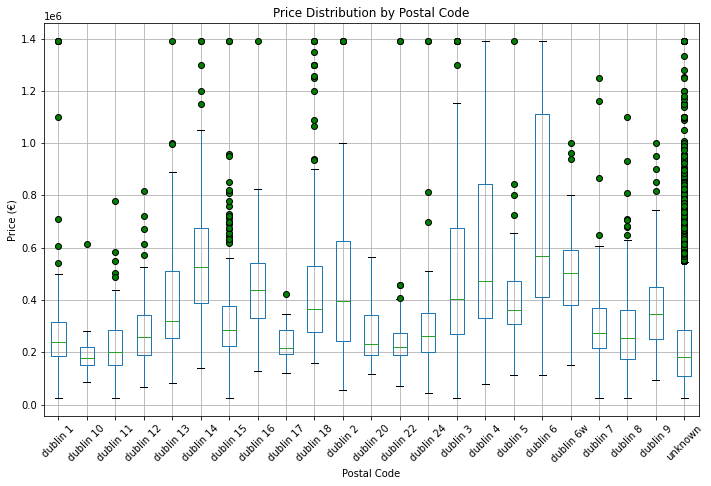

In [11]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['Price_€_VAT_incl'], by=['Postal_Code'], flierprops=flierprops, figsize=(10,7))
plt.title("Price Distribution by Postal Code")
plt.xlabel("Postal Code")
plt.ylabel("Price (€)")
plt.suptitle("")
plt.xticks(rotation=45);
plt.tight_layout()

#### Observations

This graph tells us that the median price tends to fluctuate strongly as the postal code changes, indicating that this feature would be useful for price prediction.

#### Section 1.x.x: County vs Price

<Figure size 432x288 with 0 Axes>

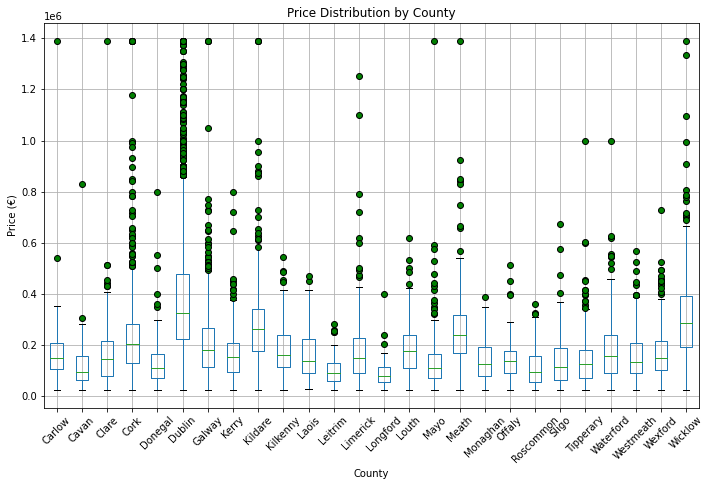

In [12]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['Price_€_VAT_incl'], by=['County'], flierprops=flierprops, figsize=(10,7))
plt.title("Price Distribution by County")
plt.xlabel("County")
plt.ylabel("Price (€)")
plt.suptitle("")
plt.xticks(rotation=45);
plt.tight_layout()

#### Observations

This graph tells us that the median price tends to fluctuate strongly as the county changes, indicating that this feature would be useful for price prediction.

#### Section 1.x.x: Description of Property vs Price

<Figure size 432x288 with 0 Axes>

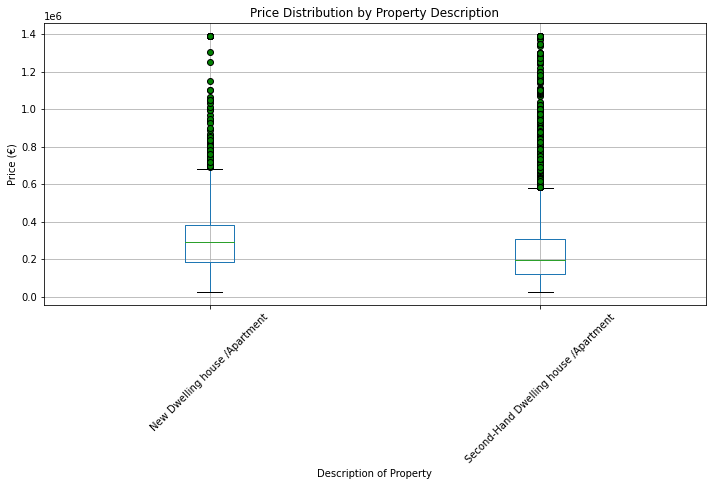

In [13]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['Price_€_VAT_incl'], by=['Description_of_Property'], flierprops=flierprops, figsize=(10,7))
plt.title("Price Distribution by Property Description")
plt.xlabel("Description of Property")
plt.ylabel("Price (€)")
plt.suptitle("")
plt.xticks(rotation=45);
plt.tight_layout()

#### Observations

There appears to be some difference in the median price of new vs second hand properties. New properties appear to sell for approximately €300,000 on average, whilst second-hand properties appear to sell for approximately €200,000 on average, suggesting that this feature would be useful for price prediction

#### Section 1.x.x: Property Size Description vs Price

<Figure size 432x288 with 0 Axes>

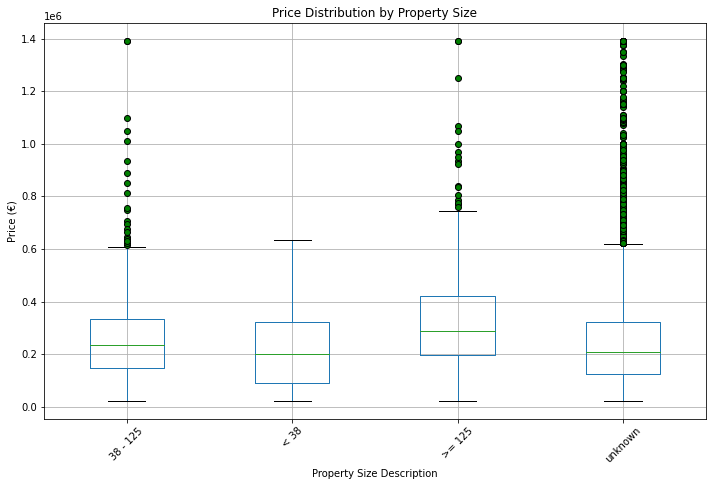

In [14]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['Price_€_VAT_incl'], by=['Property_Size_Description'], flierprops=flierprops, figsize=(10,7))
plt.title("Price Distribution by Property Size")
plt.xlabel("Property Size Description")
plt.ylabel("Price (€)")
plt.suptitle("")
plt.xticks(rotation=45);
plt.tight_layout()

#### Observations

We can see from the graph above that bigger houses tend to be more expensive on average, suggesting that this feature would be useful for price prediction

#### Section 1.x.x: Month of Sale vs Price

<Figure size 432x288 with 0 Axes>

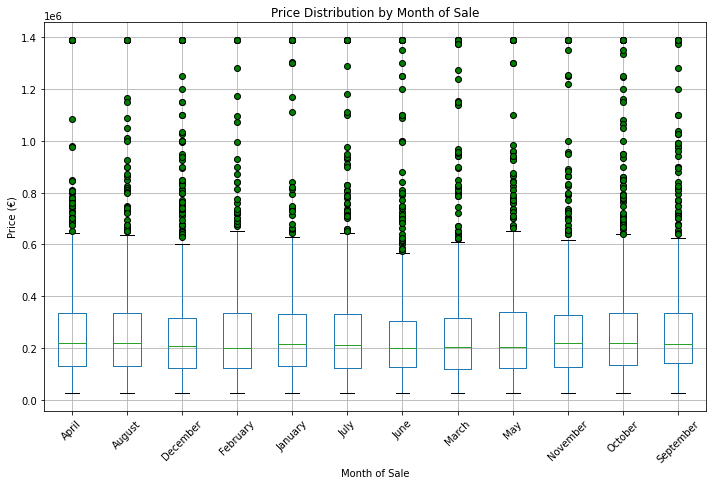

In [15]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['Price_€_VAT_incl'], by=['Month_of_Sale'], flierprops=flierprops, figsize=(10,7))
plt.title("Price Distribution by Month of Sale")
plt.xlabel("Month of Sale")
plt.ylabel("Price (€)")
plt.suptitle("")
plt.xticks(rotation=45);
plt.tight_layout()

#### Observations

We observe some variation in average price as the month of sale varies, however, this variation does not appear to be material, so we do not recommend including this feature in our final analysis

#### Section 1.x.x: Quarter of Sale vs Price

<Figure size 432x288 with 0 Axes>

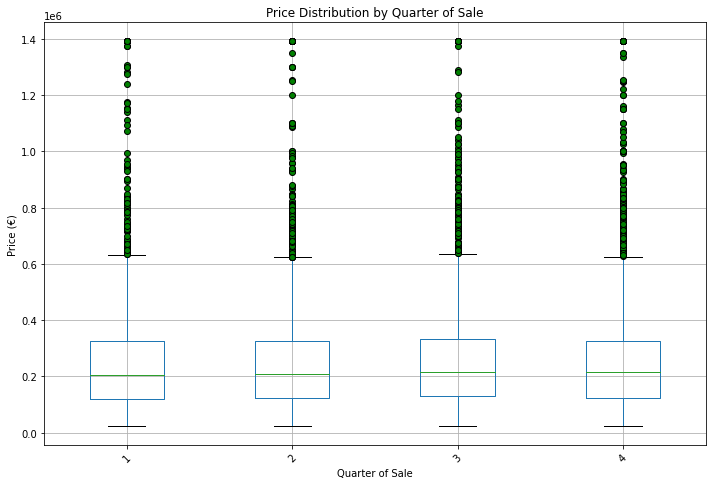

In [16]:
plt.figure()
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df.boxplot(column=['Price_€_VAT_incl'], by=['Quarter_of_Sale'], flierprops=flierprops, figsize=(10,7))
plt.title("Price Distribution by Quarter of Sale")
plt.xlabel("Quarter of Sale")
plt.ylabel("Price (€)")
plt.suptitle("")
plt.xticks(rotation=45);
plt.tight_layout()

#### Observations

Again, we observe some variation in price as the quarter of sale varies, however, there is not enough variation to justify the inclusion of this feature in our final model (all quarters appear to have a median associated property price of approximately €200,000, indicating that this feature would yield very minimal predictive power)

#### Section 1.x.x: Final Thoughts/Feature selection

All features seem as though they have some relationship with the price feature with the exception of month of sale and quarter of sale. The distribution of price values does not appear to vary according as the month/quarter of sale varies. We can conclude from this that all variables except month of sale and quarter of sale should be included in our models.

#### Section 1.x.x: Drop unused features

In [17]:
X_train.drop(["Month_of_Sale", "Quarter_of_Sale"], axis=1, inplace=True)
X_test.drop(["Month_of_Sale", "Quarter_of_Sale"], axis=1, inplace=True)

### Section 1.x - Reencode categorical variables using binary encoding

In [18]:
category_columns = X_train.select_dtypes(['category']).columns

for each in category_columns:
    dummies = pd.get_dummies(X_train[each], prefix=each, drop_first = True)
    X_train = pd.concat([X_train, dummies], axis=1)
X_train = X_train.drop(category_columns, axis=1)

for each in category_columns:
    dummies = pd.get_dummies(X_test[each], prefix=each, drop_first = True)
    X_test = pd.concat([X_test, dummies], axis=1)
X_test = X_test.drop(category_columns, axis=1)

## Section 2: Linear Regression

### Section 2.x: Train a linear regression model

In [19]:
linreg = LinearRegression().fit(X_train, y_train)

#### Section 2.x.x: Examine the coefficients of the linear regression model

In [20]:
(pd.DataFrame({'coef':linreg.coef_, 'category':X_train.columns})
.sort_values(by = 'coef', ascending = False)
.set_index('category'))

,coef
category,
Postal_Code_dublin 6,360711.324014
Postal_Code_dublin 4,269247.767293
County_Dublin,232910.067935
Postal_Code_dublin 3,221238.236578
Postal_Code_dublin 14,214253.224484
Postal_Code_dublin 6w,195917.466226
Postal_Code_dublin 18,171512.939003
Postal_Code_dublin 2,167089.657116
County_Wicklow,158942.607573


### Section 2.x: Interpretation of linear regression model

From our initial coefficients, we can see that being located in certain postal code districts and counties can significantly bring up/down the average property price. For example, the property price decreases by €139,569 on average when you move from the base case (Dublin 1) to Dublin 10, while the property price increases by €360,711 on average when you move from the base case (Dublin 1) to Dublin 6. Our base case for counties is Carlow, as this was the first county alphabetically. We see that moving from Carlow to counties like Dublin, Wicklow, and Kildare drastically increases the average property price, while moving from Carlow to Leitrim, Longford, and Roscommon drastically decreases the average property price. This aligns with our initial expectations (properties near Dublin, the central economic hub of Ireland, tend to be more valuable on average, whilst properties that are located far away from commercial activity tend to be less valuable on average).

We also see that the value of properties go down when you move from a new house to a second-hand dwelling house/apartment, which is what we would expect (people are inclined to pay less for second-hand houses, as these houses tend to be in poorer condition on average, and can often require additional renovations which need to be factored into the cost). The property price is also impacted by size. People appear to be enclined to pay more for a bigger property, and less for a smaller property, which also aligns with our expectations (in general, people prefer having more space).

### Section 2.x: Training set predictions

#### Obtain the actual and predicted price values for the first 10 training samples

In [21]:
first_10_x = X_train.head(10)
linreg_training_10_predictions = list(linreg.predict(first_10_x))
training_10_actual = list(y_train.head(10))

#### Compare predicted vs actual price values for the first 10 training samples

In [22]:
for i in range(len(linreg_training_10_predictions)):
    print(f"Predicted: {round(linreg_training_10_predictions[i])}\t Actual: {training_10_actual[i]}\t Difference: {round(linreg_training_10_predictions[i]) - training_10_actual[i]}")

Predicted: 219444	 Actual: 206000.0	 Difference: 13444.0
Predicted: 318939	 Actual: 352000.0	 Difference: -33061.0
Predicted: 237266	 Actual: 265000.0	 Difference: -27734.0
Predicted: 219444	 Actual: 230000.0	 Difference: -10556.0
Predicted: 373333	 Actual: 260000.0	 Difference: 113333.0
Predicted: 159794	 Actual: 66500.0	 Difference: 93294.0
Predicted: 209441	 Actual: 100760.0	 Difference: 108681.0
Predicted: 377576	 Actual: 259999.0	 Difference: 117577.0
Predicted: 219444	 Actual: 82500.0	 Difference: 136944.0
Predicted: 179368	 Actual: 152000.0	 Difference: 27368.0


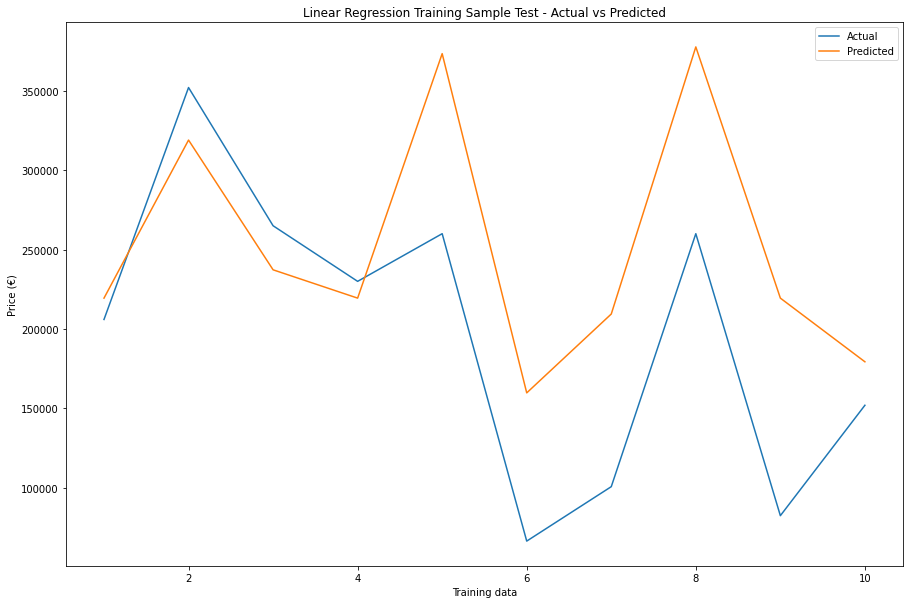

In [23]:
plt.figure(figsize=(15, 10))
plt.plot([x for x in range(1, len(linreg_training_10_predictions) + 1)], training_10_actual, label="Actual")
plt.plot([x for x in range(1, len(linreg_training_10_predictions) + 1)], linreg_training_10_predictions, label="Predicted")
plt.title("Linear Regression Training Sample Test - Actual vs Predicted")
plt.xlabel("Training data")
plt.ylabel("Price (€)")
plt.legend()
plt.show()

#### Observations

Based on the first 10 rows of training data, our model seems to be able to predict some property prices reasonably accurately (within €10,000/€20,000). However, some predictions are inaccurate (> €100,000). Our model doesn't appear to be able to handle cases where the house price is very low or very high, and appears to overestimate the house price in most cases.

#### Evaluation measures on full training dataset

In [24]:
linreg_train_predictions = linreg.predict(X_train)
print(f"R2 Score: {r2_score(y_train, linreg_train_predictions)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train, linreg_train_predictions, squared=False)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, linreg_train_predictions)}")

R2 Score: 0.33094972836263026
Root Mean Squared Error: 176185.5094770836
Mean Absolute Error: 112648.37210394115


#### Findings so far

The R squared value for our linear model is approximately 0.33, which indicates that our trained linear regression model only explains roughly 33% of the observed price variance. The mean absolute error is €112,648 and the root mean squared error is €176,185 which implies that our model will generally predict the price of houses very poorly. Ideally, we would prefer predictions to be +/- €10,000 away from the actual value.

### Section 2.x: Evaluation of linear regression model (hold-out sampling)

In [25]:
linreg_test_predictions = linreg.predict(X_test)
print(f"R2 Score: {r2_score(y_test, linreg_test_predictions)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, linreg_test_predictions, squared=False)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, linreg_test_predictions)}")

R2 Score: 0.3414363946875306
Root Mean Squared Error: 178373.8843135127
Mean Absolute Error: 115479.51607864258


#### Comparison between training and test results

The performance of our linear regression model on the training sample does not appear to be significantly different from the performance of our model on the test sample. We obtained a slightly higher R squared value when evaluating on the test sample, which indicates that the model performed slightly better in the test case. However, we also obtained slightly higher values for root mean squared error and mean absolute error, which suggests that the model performed slightly worse in the test case. The discrepancies in performance between the test and training case are very small, so we can conclude that there is no evidence that our linear regression model suffered from overfitting to the training data.

### Section 2.x: Cross Validation of linear regression model

In [26]:
lin_reg_cv_r2 = cross_val_score(LinearRegression(), X_train, y_train, scoring="r2", cv=3)
print(f"CV R Squared Scores: {lin_reg_cv_r2}")
print(f"CV R Squared Mean Score: {lin_reg_cv_r2.mean()}")
print(f"CV R Squared Standard Deviation of Score: {lin_reg_cv_r2.std()}")

CV R Squared Scores: [0.33110748 0.31262002 0.30969972]
CV R Squared Mean Score: 0.3178090730613095
CV R Squared Standard Deviation of Score: 0.009478669013808314


In [27]:
lin_reg_cv_mae = cross_val_score(LinearRegression(), X_train, y_train, scoring="neg_mean_absolute_error", cv=3)
print(f"CV MAE Scores: {lin_reg_cv_mae * -1}")
print(f"CV MAE mean score: {lin_reg_cv_mae.mean() * -1}")
print(f"CV MAE std score: {lin_reg_cv_mae.std()}")

CV MAE Scores: [115789.62080723 110774.87153504 114165.45289034]
CV MAE mean score: 113576.64841086774
CV MAE std score: 2089.1697875826035


In [28]:
lin_reg_cv_rmse = cross_val_score(LinearRegression(), X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f"CV RMSE Scores: {lin_reg_cv_rmse * -1}")
print(f"CV RMSE mean score: {lin_reg_cv_rmse.mean() * -1}")
print(f"CV RMSE std score: {lin_reg_cv_rmse.std()}")

CV RMSE Scores: [180691.61059841 172684.04307597 179950.62257754]
CV RMSE mean score: 177775.42541730893
CV RMSE std score: 3612.8378892512023


#### Comparison between hold-out sampling and k-fold cross validation

There does not appear to be significant variation between cross validation and hold-out sampling in this case. If our model had performed well when one train/test split was used, but had performed worse when k-fold cross validation was used, we would conclude that evaluation metrics computed during hold-out sampling provided an over-optimistic view of the generalisability of our model. However, this does not seem to have been the case in this instance, and the metrics evaluated during both hold-out sampling and k-fold cross validation give a reasonable view of how our model might generalise to unseen data.

## Section 3: Decision Trees

### Section 3.x: Train a decision tree

Note that we have set a max depth = 20 and min_samples_leaf = 10 during the construction of our decision tree regressor to prevent overfitting to the data. This implies that there should be sufficient representation in each leaf node, and the rules used to partition the dataset into the different leaf nodes should not be too complicated.

In [29]:
# Instantiate sklearn estimator, fit with training set.
dtr = DecisionTreeRegressor(max_depth=20, random_state=1, min_samples_leaf=10)
dtr.fit(X_train, y_train)
print(dtr)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, random_state=1)


### Section 3.x: Interpretation of decision tree model

In [30]:
# Compute the importance of each feature based on the trained decision tree classifier
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':dtr.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

,feature,importance
26,County_Dublin,0.597113
16,Postal_Code_dublin 6,0.047271
46,County_Wicklow,0.037963
47,Description_of_Property_Second-Hand Dwelling h...,0.036618
50,Property_Size_Description_unknown,0.030976
14,Postal_Code_dublin 4,0.029445
29,County_Kildare,0.028418
24,County_Cork,0.019111
1,Postal_Code_dublin 11,0.017852
4,Postal_Code_dublin 14,0.014793


#### Graph the decision tree

In [31]:
# create a Graphviz file which has extension .dot
with open("decision_tree.dot", 'w') as f:
    f = export_graphviz(dtr, out_file=f, feature_names=X_train.columns)

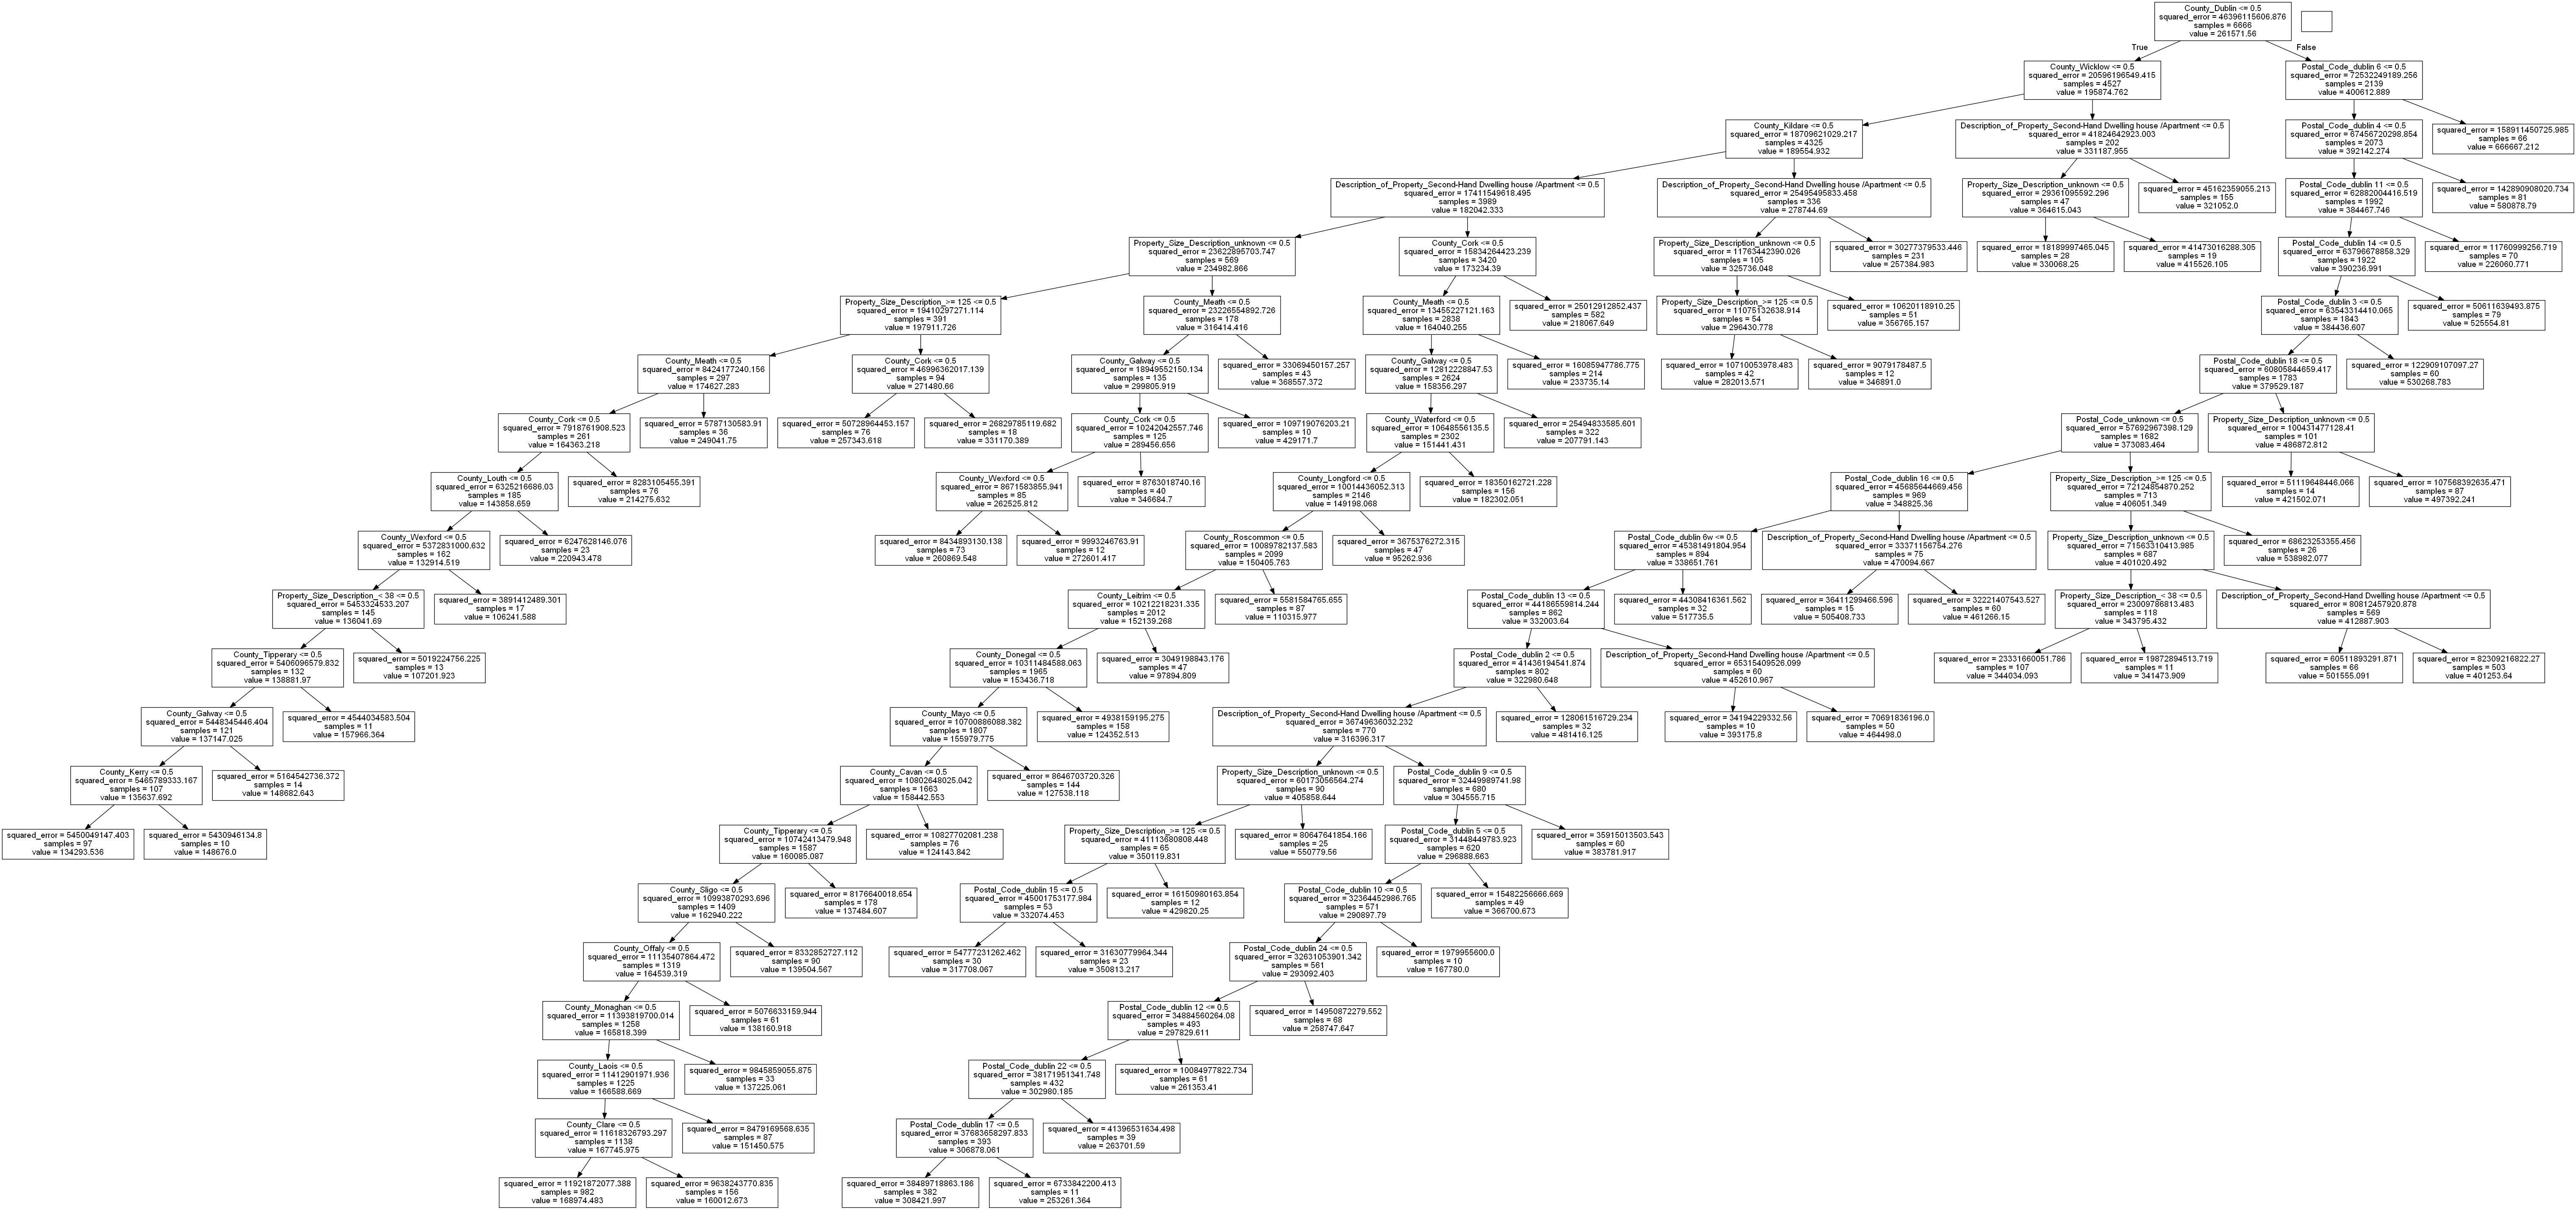

In [32]:
graphs = pydot.graph_from_dot_file('decision_tree.dot')
graph = graphs[0]

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)

view_pydot(graph)

#### Interpretation of decision tree model

Being located in county Dublin appears to be the biggest indicator of property price according to this model by far. Other important characteristics of properties according to this model are the following: being located in Dublin 6, being located in Wicklow, having an unknown property size etc. All other important characteristics can be seen in the graph and feature importance table above.

### Section 3.x: Training set predictions

In [33]:
dtr_training_10_predictions = list(dtr.predict(first_10_x))

In [34]:
for i in range(len(dtr_training_10_predictions)):
    print(f"Predicted: {round(dtr_training_10_predictions[i])}\t Actual: {training_10_actual[i]}\t Difference: {round(dtr_training_10_predictions[i]) - training_10_actual[i]}")

Predicted: 218068	 Actual: 206000.0	 Difference: 12068.0
Predicted: 321052	 Actual: 352000.0	 Difference: -30948.0
Predicted: 233735	 Actual: 265000.0	 Difference: -31265.0
Predicted: 218068	 Actual: 230000.0	 Difference: -11932.0
Predicted: 383782	 Actual: 260000.0	 Difference: 123782.0
Predicted: 168974	 Actual: 66500.0	 Difference: 102474.0
Predicted: 207791	 Actual: 100760.0	 Difference: 107031.0
Predicted: 344034	 Actual: 259999.0	 Difference: 84035.0
Predicted: 218068	 Actual: 82500.0	 Difference: 135568.0
Predicted: 168974	 Actual: 152000.0	 Difference: 16974.0


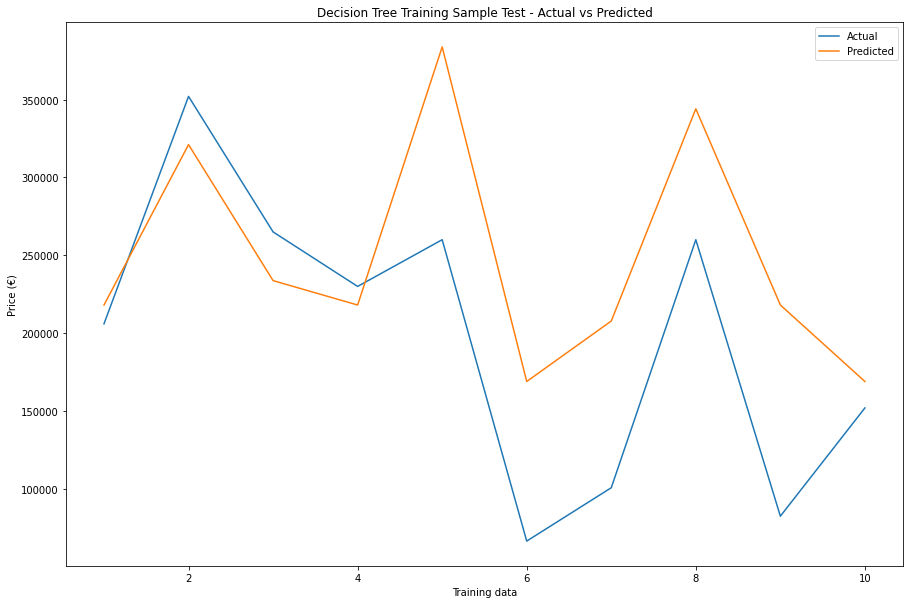

In [35]:
plt.figure(figsize=(15, 10))
plt.plot([x for x in range(1, len(dtr_training_10_predictions) + 1)], training_10_actual, label="Actual")
plt.plot([x for x in range(1, len(dtr_training_10_predictions) + 1)], dtr_training_10_predictions, label="Predicted")
plt.title("Decision Tree Training Sample Test - Actual vs Predicted")
plt.xlabel("Training data")
plt.ylabel("Price (€)")
plt.legend()
plt.show()

In [36]:
dtr_train_predictions = dtr.predict(X_train)
print(f"R2 Score: {r2_score(y_train, dtr_train_predictions)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train, dtr_train_predictions, squared=False)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, dtr_train_predictions)}")

R2 Score: 0.3297234629442928
Root Mean Squared Error: 176346.8959233857
Mean Absolute Error: 112494.75282655186


#### Findings so far

The results for the decision tree regressor are very similar to the linear model regressor. Approximately 33% of the price variance is explained by our trained decision tree, and the mean absolute error and root mean squared error are again greater than €100,000 (€112,494 and €176,346 respectively).

### Section 3.x: Evaluation of Decision Tree

In [37]:
dtr_test_predictions = dtr.predict(X_test)
print(f"R2 Score: {r2_score(y_test, dtr_test_predictions)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, dtr_test_predictions, squared=False)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, dtr_test_predictions)}")

R2 Score: 0.33624028260639693
Root Mean Squared Error: 179076.19281941903
Mean Absolute Error: 115623.66090048915


#### Comparison between training and test results

Our decision tree model had a slightly higher R squared when evaluated using the test dataset, which indicates better performance. Our decision tree model also had a slightly higher RMSE and MAE, which indicates poorer performance. Ultimately, we view these discrepancies as immaterial, and conclude that performance was similar when evaluation was performed on the test set vs the training set. We can conclude from this that our model likely did not suffer from overfitting to the training data.

### Section 3.x: Cross validation of a decision tree

In [38]:
dtr_cv_r2 = cross_val_score(DecisionTreeRegressor(max_depth=20, random_state=1, min_samples_leaf=10), X_train, y_train, scoring="r2", cv=3)
print(f"CV R Squared Scores: {dtr_cv_r2}")
print(f"CV R Squared Mean Score: {dtr_cv_r2.mean()}")
print(f"CV R Squared Standard Deviation of Score: {dtr_cv_r2.std()}")

CV R Squared Scores: [0.31969019 0.30943609 0.30139412]
CV R Squared Mean Score: 0.3101734670138851
CV R Squared Standard Deviation of Score: 0.0074875149417939655


In [39]:
dtr_cv_mae = cross_val_score(DecisionTreeRegressor(max_depth=20, random_state=1, min_samples_leaf=10), X_train, y_train, scoring="neg_mean_absolute_error", cv=3)
print(f"CV MAE Scores: {dtr_cv_mae * -1}")
print(f"CV MAE Mean Score: {dtr_cv_mae.mean() * -1}")
print(f"CV MAE Standard Deviation of Score: {dtr_cv_mae.std()}")

CV MAE Scores: [116334.78707477 110934.26285997 115356.55550146]
CV MAE Mean Score: 114208.53514540072
CV MAE Standard Deviation of Score: 2349.45078718429


In [40]:
dtr_cv_rmse = cross_val_score(DecisionTreeRegressor(max_depth=20, random_state=1, min_samples_leaf=10), X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f"CV RMSE Scores: {dtr_cv_rmse * -1}")
print(f"CV RMSE Mean Score: {dtr_cv_rmse.mean() * -1}")
print(f"CV RMSE Standard Deviation of Score: {dtr_cv_rmse.std()}")

CV RMSE Scores: [182227.19339447 173083.51506166 181029.95659608]
CV RMSE Mean Score: 178780.2216840696
CV RMSE Standard Deviation of Score: 4057.724628754181


#### Comparison between hold-out sampling and k-fold cross validation

There again does not appear to be any significant difference between the evaluation metrics derived using hold-out sampling vs k-fold cross validation. This suggests that both approaches provide a reasonable indication as to the generalisability of our decision tree model.

## Section 4: Random Forest

### Section 4.x: Train a Random Forest

We have again opted to set a max depth = 20 and a min leaf samples = 10 in order to prevent overfitting to the data, and so that our results are comparable with the decision tree results, where the same hyperparameters were used.

In [41]:
rfr = RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1, max_depth=20, min_samples_leaf=10)
rfr.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=10, oob_score=True,
                      random_state=1)

### Section 4.x: Interpretation of Random Forest

In [42]:
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfr.feature_importances_})
feature_importance.sort_values('importance', ascending=False)

,feature,importance
26,County_Dublin,0.587630
16,Postal_Code_dublin 6,0.046454
46,County_Wicklow,0.038682
47,Description_of_Property_Second-Hand Dwelling h...,0.037969
50,Property_Size_Description_unknown,0.030194
14,Postal_Code_dublin 4,0.029999
29,County_Kildare,0.026046
24,County_Cork,0.019027
37,County_Meath,0.017980
49,Property_Size_Description_>= 125,0.017506


Text(0.5, 0, 'Random Forest Feature Importance')

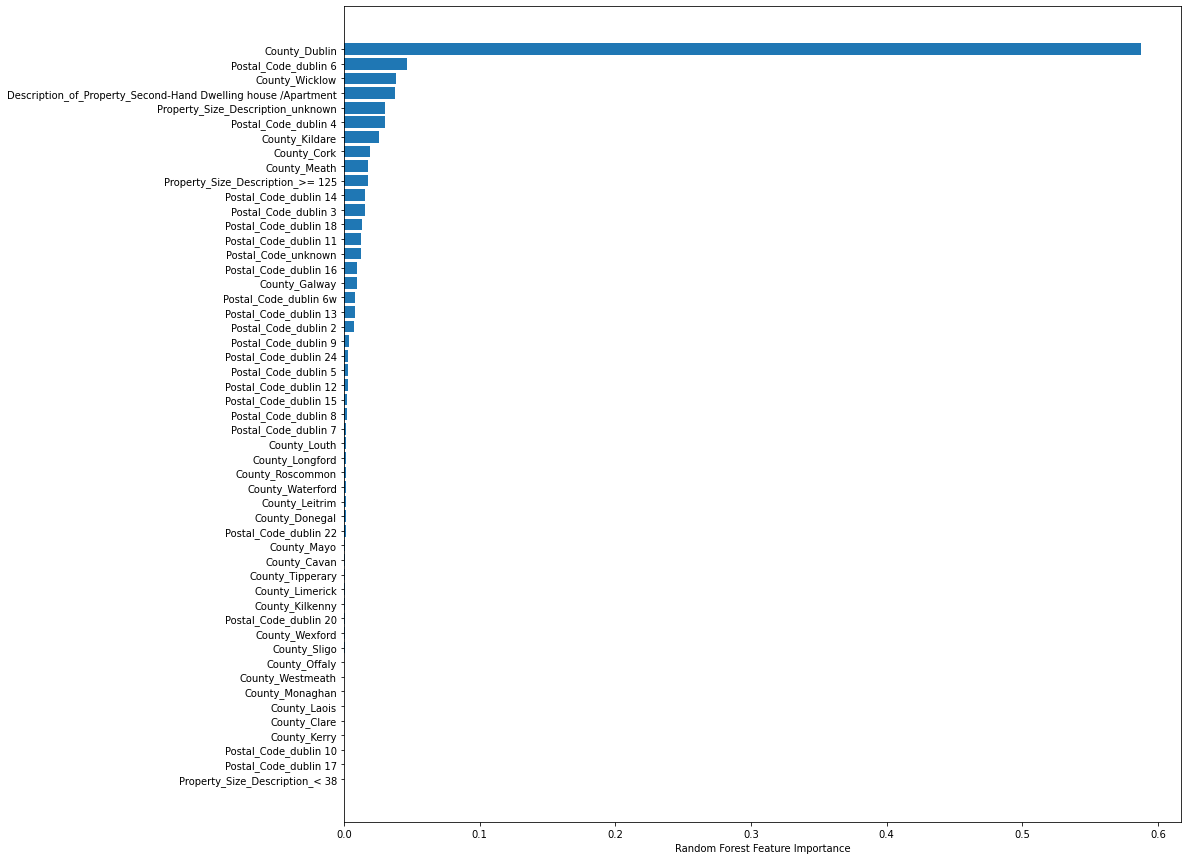

In [43]:
# https://mljar.com/blog/feature-importance-in-random-forest/
sorted_idx = rfr.feature_importances_.argsort()
plt.figure(figsize=(15,15))
plt.barh(X_train.columns[sorted_idx], rfr.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

#### Observations

The random forest model made very similar decisions to the decision tree model. It put a lot of importance on the property being located in Dublin, and also considered the property's location in Dublin 6 and Wicklow to be important.

### Section 4.x: Training set predictions

In [44]:
rfr_training_10_predictions = list(rfr.predict(first_10_x))

In [45]:
for i in range(len(rfr_training_10_predictions)):
    print(f"Predicted: {round(rfr_training_10_predictions[i])}\t Actual: {training_10_actual[i]}\t Difference: {round(rfr_training_10_predictions[i]) - training_10_actual[i]}")

Predicted: 217760	 Actual: 206000.0	 Difference: 11760.0
Predicted: 322469	 Actual: 352000.0	 Difference: -29531.0
Predicted: 234123	 Actual: 265000.0	 Difference: -30877.0
Predicted: 217760	 Actual: 230000.0	 Difference: -12240.0
Predicted: 382173	 Actual: 260000.0	 Difference: 122173.0
Predicted: 162272	 Actual: 66500.0	 Difference: 95772.0
Predicted: 208422	 Actual: 100760.0	 Difference: 107662.0
Predicted: 341509	 Actual: 259999.0	 Difference: 81510.0
Predicted: 217760	 Actual: 82500.0	 Difference: 135260.0
Predicted: 178322	 Actual: 152000.0	 Difference: 26322.0


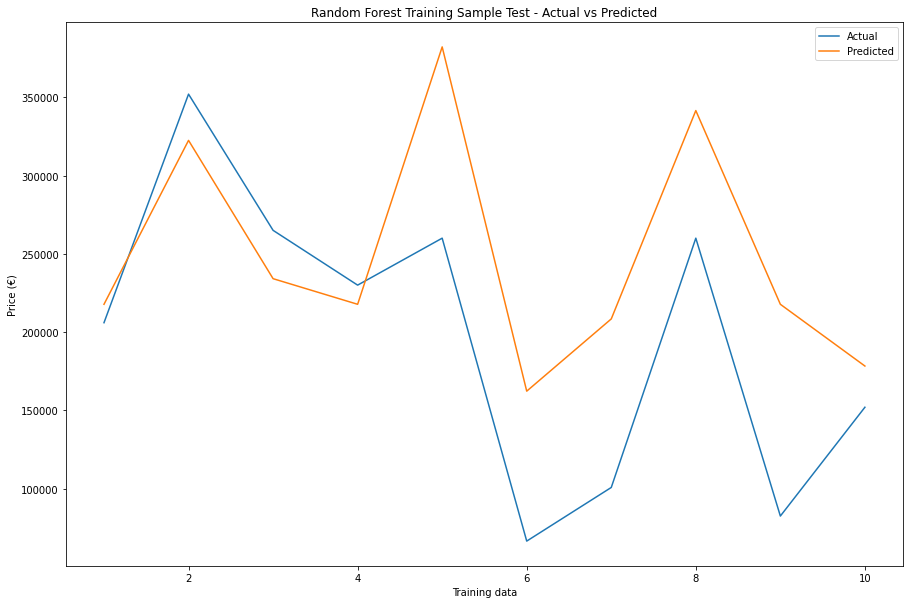

In [46]:
plt.figure(figsize=(15, 10))
plt.plot([x for x in range(1, len(rfr_training_10_predictions) + 1)], training_10_actual, label="Actual")
plt.plot([x for x in range(1, len(rfr_training_10_predictions) + 1)], rfr_training_10_predictions, label="Predicted")
plt.title("Random Forest Training Sample Test - Actual vs Predicted")
plt.xlabel("Training data")
plt.ylabel("Price (€)")
plt.legend()
plt.show()

In [47]:
rfr_train_predictions = rfr.predict(X_train)
print(f"R2 Score: {r2_score(y_train, rfr_train_predictions)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train, rfr_train_predictions, squared=False)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, rfr_train_predictions)}")

R2 Score: 0.32990938270746273
Root Mean Squared Error: 176322.43687911014
Mean Absolute Error: 112334.49909585848


#### Findings so far

Our random forest model does not appear to perform significantly better or worse than our previous two models. It again explains roughly 33% of the price variance, and has a mean absolute error and a root mean squared error > €100,000 (€112,334 and €176,322 respectively). This tells us that the use of features such as location, size, and description (new/second-hand) do not tell us the whole story about price. This idea will be discussed further in section 5, when we evaluate the performance of all of our models and seek out ways to optimise these models.

### Section 4.x: Evaluation of Random Forest

In [48]:
rfr_test_predictions = rfr.predict(X_test)
print(f"R2 Score: {r2_score(y_test, rfr_test_predictions)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, rfr_test_predictions, squared=False)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, rfr_test_predictions)}")

R2 Score: 0.3376982043503427
Root Mean Squared Error: 178879.41785056022
Mean Absolute Error: 115420.37858771927


#### Comparison between training and test results

Our random forest model had a slightly higher R squared when evaluated using the test dataset, which indicates better performance. Our random forest model also had a slightly higher RMSE and MAE, which indicates poorer performance. Ultimately, we view these discrepancies as immaterial, and conclude that performance was similar when evaluation was performed on the test set vs the training set. This tells us that our trained random forest model did not suffer from overfitting to the training data.

### Section 4.x: Cross validation of random forest

In [49]:
rfr_cv_r2 = cross_val_score(RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1, max_depth=20, min_samples_leaf=10), X_train, y_train, scoring="r2", cv=3)
print(f"CV R Squared Scores: {rfr_cv_r2}")
print(f"CV R Squared Mean Score: {rfr_cv_r2.mean()}")
print(f"CV R Squared Standard Deviation of Score: {rfr_cv_r2.std()}")

CV R Squared Scores: [0.32075375 0.31009076 0.30427416]
CV R Squared Mean Score: 0.31170622315760005
CV R Squared Standard Deviation of Score: 0.006824050827575375


In [50]:
rfr_cv_mae = cross_val_score(RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1, max_depth=20, min_samples_leaf=10), X_train, y_train, scoring="neg_mean_absolute_error", cv=3)
print(f"CV MAE Scores: {rfr_cv_mae * -1}")
print(f"CV MAE Mean Score: {rfr_cv_mae.mean() * -1}")
print(f"CV MAE Standard Deviation of Score: {rfr_cv_mae.std()}")

CV MAE Scores: [116069.63821829 110789.723858   114920.36098536]
CV MAE Mean Score: 113926.57435388274
CV MAE Standard Deviation of Score: 2267.1689857136134


In [51]:
rfr_cv_rmse = cross_val_score(RandomForestRegressor(n_estimators=100, max_features='auto', oob_score=True, random_state=1, max_depth=20, min_samples_leaf=10), X_train, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f"CV RMSE Scores: {rfr_cv_rmse * -1}")
print(f"CV RMSE Mean Score: {rfr_cv_rmse.mean() * -1}")
print(f"CV RMSE Standard Deviation of Score: {rfr_cv_rmse.std()}")

CV RMSE Scores: [182084.69526884 173001.45288695 180656.41804201]
CV RMSE Mean Score: 178580.85539926626
CV RMSE Standard Deviation of Score: 3988.090040356064


#### Comparison between hold-out sampling and k-fold cross validation

The differences between results derived from hold-out sampling and k-fold cross validation were not significant. We can conclude from this that the results derived from both hold-out sampling and k-fold cross validation provide a realistic indication of the generalisability of our final model.

### Section 4.x: Random forest out of sample error

In [52]:
rfr.oob_score_

0.31361929292214064

#### Comparison between the two previous metrics and out of sample error

The two previous metrics (derived from hold-out sampling and k-fold cross validation) and the out of sample error were all similar, indicating that all metrics provide a realistic view of the generalisability of our model.

## Section 5: Improving Predictive Models

Our results from sections 2-4 tell us that the performance of all of our models in predicting prices is roughly equal. There was no model which consistantly performed better than the others.

### Section 5.x: Optimal model vs average yearly price model

#### Construct our baseline model

The baseline model always predicts the yearly average each time. We will construct this model by replacing our X train data with a dataset that only includes the year of sale. When we use this new dataset to construct a linear regression model, the end result will be a model that always predicts a property's price to be the average price in the year in which it was sold.

In [53]:
# Use the year of sale as the training data
X_train_date["Year_of_Sale"] = X_train_date["Date_of_Sale"].dt.year.astype("category")
X_train_date.drop(["Date_of_Sale"], axis=1, inplace=True)

In [54]:
X_test_date["Year_of_Sale"] = X_test_date["Date_of_Sale"].dt.year.astype("category")
X_test_date.drop(["Date_of_Sale"], axis=1, inplace=True)

In [55]:
# Perform binary encoding on the year of sale column
dummies = pd.get_dummies(X_train_date["Year_of_Sale"], prefix="Year_of_Sale", drop_first = True)
X_train_date = pd.concat([X_train_date, dummies], axis=1)
X_train_date = X_train_date.drop(["Year_of_Sale"], axis=1)

dummies = pd.get_dummies(X_test_date["Year_of_Sale"], prefix="Year_of_Sale", drop_first = True)
X_test_date = pd.concat([X_test_date, dummies], axis=1)
X_test_date = X_test_date.drop(["Year_of_Sale"], axis=1)

In [56]:
# Train a linear regression model using just the feature year of sale
# This is equivalent to predicting the average price each year
baseline_model = LinearRegression()
baseline_model.fit(X_train_date, y_train)

LinearRegression()

#### Evaluation of the baseline model using hold-out sampling

In [57]:
# Test the performance of the baseline model
baseline_predictions = baseline_model.predict(X_test_date)
print(f"R2 Score: {r2_score(y_test, baseline_predictions)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, baseline_predictions, squared=False)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, baseline_predictions)}")

R2 Score: 0.03890209104252462
Root Mean Squared Error: 215484.5924558747
Mean Absolute Error: 143173.1007010464


#### Observations

As we expected, all of our models constructed in sections 2-4 performed better than a model which simply predicts the average price each year. The baseline model was only able to capture approximately 4% of the variation in prices (compared with approximately 33% in the case of our models). The baseline model also had much higher values for both root mean squared error and mean absolute error. The root mean squared error for the majority of our models was around €176k, whereas the root mean squared error for our baseline model was €215,484. The mean absolute error for the majority of our models was around €113k, whereas the mean absolute error for our baseline model was €143,173. This tells us that, while our models do not perform well, they perform much better than the baseline model, which we consider a success.

### Section 5.x: Problem understanding/improving optimal model

#### Section 5.x.x: Understanding of problem

As was mentioned previously, the performance of all of our models from section 2-4 was comparable. There was no model that stood out as being high-performing, and they all seemed to make very similar decisions. All models put a significant weight on the property being located in Dublin (or nearby Dublin), suggesting that the models learnt something from the data (that properties close to the economic hub of Ireland tend to be valued higher). The models also learnt that being located in certain postal codes within Dublin resulted in higher/lower prices (Dublin 6 and Dublin 4 were locations in which the model predicted that property prices were high). The models also concluded that properties that were large and new were more valuable than properties that were small and second-hand. All of these results align with prior expectations.

While it is good that our models provided some insight, and that we can map these insights with our initial expectations (implying that our models are interpretable), we are disappointed in our final results. The R squared of our models were quite low, and both the mean absolute error and the root mean squared error were quite high. This indicates that, while our model made reasonable decisions, it was not flexible enough to capture a significant proportion of the variation observed in prices. We feel as though obtaining more data would be helpful in building a more useful machine learning model. In the previous task, we explored the possibility of using a web scraping script to obtain data from www.myhome.ie, for example, the number of beds in the property, the number of bathrooms, the energy rating, a more detailed description of the property (bungalow/semi-detached/terraced etc.). Unfortunately, this data was only available for certain properties, and thus we did not feel as though it was usable in our final model. 

We also assumed that the inclusion of macroeconomic factors would be useful in our analysis. In the previous tasks, we observed that prices appeared to be highly dependent on the economic conditions at the time, as given by Ireland's modified GNI. However, this data is too time-dependent. We cannot be sure that we will have access to this data at the time of prediction, and would be forced to use time series analysis or some other method to construct a reasonable proxy for this quantity. This is sub-optimal, so we have neglected to consider macroeconomic factors in our model. Perhaps this application would be more suited to time series analysis instead of machine learning. The implementation of a time series model is beyond the scope of this assignment.

#### Section 5.x.x: Final Results

In [78]:
print("Cross Validation Results\t R Squared\t Mean Absolute Error\t Root Mean Squared Error")
print(f"Linear Regression\t {lin_reg_cv_r2.mean()}\t {lin_reg_cv_mae.mean() * -1}\t {lin_reg_cv_rmse.mean() * -1}")
print(f"Decision Tree\t\t {dtr_cv_r2.mean()}\t {dtr_cv_mae.mean() * -1}\t {dtr_cv_rmse.mean() * -1}")
print(f"Random Forest\t\t {rfr_cv_r2.mean()}\t {rfr_cv_mae.mean() * -1}\t {rfr_cv_rmse.mean() * -1}")

Cross Validation Results	 R Squared	 Mean Absolute Error	 Root Mean Squared Error
Linear Regression	 0.3178090730613095	 113576.64841086774	 177775.42541730893
Decision Tree		 0.3101734670138851	 114208.53514540072	 178780.2216840696
Random Forest		 0.31170622315760005	 113926.57435388274	 178580.85539926626


#### Section 5.x.x: Optimisations

#### Include all possible features

In the first section, we dropped month and quarter of sale as they did not appear to have a significant impact on price based on our feature plots. We will now add these features back into our model and observe the impact that this has on our model's performance

In [59]:
X_train_all, X_test_all, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=4)

In [60]:
X_train_all = X_train_all.drop(["Date_of_Sale"], axis=1)
X_test_all = X_test_all.drop(["Date_of_Sale"], axis=1)

In [61]:
category_columns = X_train_all.select_dtypes(['category']).columns

for each in category_columns:
    dummies = pd.get_dummies(X_train_all[each], prefix=each, drop_first = True)
    X_train_all = pd.concat([X_train_all, dummies], axis=1)
X_train_all = X_train_all.drop(category_columns, axis=1)

for each in category_columns:
    dummies = pd.get_dummies(X_test_all[each], prefix=each, drop_first = True)
    X_test_all = pd.concat([X_test_all, dummies], axis=1)
X_test_all = X_test_all.drop(category_columns, axis=1)

In [79]:
lin_reg_cv_all_features_r2 = cross_val_score(LinearRegression(), X_train_all, y_train, scoring="r2", cv=3)
print(f"CV R Squared Scores: {lin_reg_cv_all_features_r2}")
print(f"CV R Squared Mean Score: {lin_reg_cv_all_features_r2.mean()}")
print(f"CV R Squared Standard Deviation of Score: {lin_reg_cv_all_features_r2.std()}")

CV R Squared Scores: [0.3289513  0.31206244 0.30879581]
CV R Squared Mean Score: 0.3166031815116318
CV R Squared Standard Deviation of Score: 0.008832691432740942


In [80]:
lin_reg_cv_all_features_mae = cross_val_score(LinearRegression(), X_train_all, y_train, scoring="neg_mean_absolute_error", cv=3)
print(f"CV MAE Scores: {lin_reg_cv_all_features_mae * -1}")
print(f"CV MAE mean score: {lin_reg_cv_all_features_mae.mean() * -1}")
print(f"CV MAE std score: {lin_reg_cv_all_features_mae.std()}")

CV MAE Scores: [115970.4009901  110877.27767777 114030.15481548]
CV MAE mean score: 113625.94449444946
CV MAE std score: 2098.811688610901


In [83]:
lin_reg_cv_all_features_rmse = cross_val_score(LinearRegression(), X_train_all, y_train, scoring="neg_root_mean_squared_error", cv=3)
print(f"CV RMSE Scores: {lin_reg_cv_all_features_rmse * -1}")
print(f"CV RMSE mean score: {lin_reg_cv_all_features_rmse.mean() * -1}")
print(f"CV RMSE std score: {lin_reg_cv_all_features_rmse.std()}")

CV RMSE Scores: [180982.60723045 172754.06652459 180068.40193512]
CV RMSE mean score: 177935.02523005256
CV RMSE std score: 3682.453227700027


#### Observations

Including the features that we ommitted from the original analysis does not seem to have improved the predictive power of our optimal model. This is not terribly surprising, as we concluded from section 1 that these features were not likely to be impactful.

### Section 5.x: Evaluation of our best model on unseen data

#### Section 5.x.x: Read in the unseen data

In [63]:
unseen_df = pd.read_csv("cleaned_unseen_data.csv")

#### Section 5.x.x: Change the data types

In [64]:
# Change the price variable to a float
unseen_df["Price_€_VAT_incl"] = unseen_df["Price_€_VAT_incl"].astype(float)

In [65]:
# Change the date of sale variable to a datetime variable
unseen_df["Date_of_Sale"] = pd.to_datetime(unseen_df["Date_of_Sale"], format="%Y-%m-%d")

In [66]:
# Change the quarter of sale variable to an object
# This is so that it can be turned into a categorical variable in the next cell
unseen_df["Quarter_of_Sale"] = unseen_df["Quarter_of_Sale"].astype("object")

In [67]:
# Select all columns of type 'object'
object_columns = unseen_df.select_dtypes(['object']).columns

# Convert selected columns to type 'category'
for column in object_columns:
    unseen_df[column] = unseen_df[column].astype('category')

Date_of_Sale                 datetime64[ns]
Postal_Code                        category
County                             category
Price_€_VAT_incl                    float64
Description_of_Property            category
Property_Size_Description          category
Month_of_Sale                      category
Quarter_of_Sale                    category
dtype: object

In [68]:
# The input variables will be all columns except for price and date of sale
X_unseen = unseen_df.drop(["Price_€_VAT_incl", "Date_of_Sale"], axis=1)

# The target variable will be property price
y_unseen = unseen_df["Price_€_VAT_incl"]

In [69]:
X_unseen.drop(["Month_of_Sale", "Quarter_of_Sale"], axis=1, inplace=True)

In [70]:
category_columns = X_unseen.select_dtypes(['category']).columns

for each in category_columns:
    dummies = pd.get_dummies(X_unseen[each], prefix=each, drop_first = True)
    X_unseen = pd.concat([X_unseen, dummies], axis=1)
X_unseen = X_unseen.drop(category_columns, axis=1)

In [73]:
X_unseen["Property_Size_Description_< 38"] = 0
X_unseen["Property_Size_Description_>= 125"] = 0
X_unseen["Property_Size_Description_unknown"] = 1

In [75]:
unseen_data_predictions = linreg.predict(X_unseen)
print(f"R2 Score: {r2_score(y_unseen, unseen_data_predictions)}")
print(f"Root Mean Squared Error: {mean_squared_error(y_unseen, unseen_data_predictions, squared=False)}")
print(f"Mean Absolute Error: {mean_absolute_error(y_unseen, unseen_data_predictions)}")

R2 Score: 0.2235442015018163
Root Mean Squared Error: 200089.24516429138
Mean Absolute Error: 124938.82896726673


#### Observations

Our model performs slightly worse on unseen data. This may be due to the absense of any data for the property size description feature.